# **LSTM Model**
---

In [ ]:
# Imports 

import numpy as np 
import pandas as pd
import seaborn as sns
import sklearn.metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
from keras.utils import to_categorical
from keras import backend as K

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold

from features import add_features

2024-10-24 05:05:13.030962: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 05:05:13.138632: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 05:05:13.275740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 05:05:13.415897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 05:05:13.458206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 05:05:13.641541: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
# -----------------------------------------------
# Step 1: Load data and features
# -----------------------------------------------

# Load preprocessed data
train = pd.read_csv('data/filtered_train_series_continuous.csv')
test = pd.read_csv('data/filtered_test_series_continuous.csv')

# Add engineered features to the dataset
train = add_features(train)
test = add_features(test)
# print(train.shape)
# print(test.shape)

# -----------------------------------------------
# Step 2: Handle missing values and Prepare data
# -----------------------------------------------

# Drop NaNs
train.dropna(inplace=True)
test.dropna(inplace=True)
# print(train.shape)
# print(test.shape)


In [3]:
def convert_to_3d(df, timestep_length=50, resample=True):
    # Ensure the DataFrame is sorted by series_id and step
    df = df.sort_values(by=["series_id", "step"])
        
    # Extract the events
    events = df["event"]
    # Remove the 'series_id' and 'events' column from the features
    features = df.drop(columns=["series_id", "event"])
    
    # SMOTE 
    smote = SMOTE(random_state=42)
    smote_series, smote_event = smote.fit_resample(features, events)
    
    if resample:
        # Split into train and eval
        X_train, X_val, Y_train, Y_val = train_test_split(smote_series, smote_event,
                                                         test_size=0.2, stratify=smote_event,
                                                         random_state=42)
        # Get the number of rows 
        num_rows_train = len(Y_train)
        num_rows_val = len(Y_val)
        
        # Truncate to the largest multiple of timestep_length
        num_rows_to_keep_train = num_rows_train - (num_rows_train % timestep_length)
        num_rows_to_keep_val = num_rows_val - (num_rows_val % timestep_length)

        # Reshape the events array
        reshaped_event_train = Y_train[:num_rows_to_keep_train].values.reshape(-1, timestep_length)
        reshaped_event_val = Y_val[:num_rows_to_keep_val].values.reshape(-1, timestep_length)

        # Reshape the dataframe into a 3D numpy array: (n_series, timesteps, features)
        reshaped_data_train = X_train[:num_rows_to_keep_train].values.reshape(-1, timestep_length, X_train.shape[1])
        reshaped_data_val = X_val[:num_rows_to_keep_val].values.reshape(-1, timestep_length, X_val.shape[1])
        return reshaped_data_train, reshaped_data_val, reshaped_event_train, reshaped_event_val
    
    # Get the number of rows in the SMOTE resampled events
    num_rows = len(smote_event)
    # Truncate to the largest multiple of timestep_length
    num_rows_to_keep = num_rows - (num_rows % timestep_length)
    
    # Reshape the events array
    reshaped_event = smote_event[:num_rows_to_keep].values.reshape(-1, timestep_length)
    # Reshape the dataframe into a 3D numpy array: (n_series, timesteps, features)
    reshaped_data = smote_series[:num_rows_to_keep].values.reshape(-1, timestep_length, smote_series.shape[1])
    
    return reshaped_data, reshaped_event

In [4]:
shaped_train_data, shaped_val_data, shaped_train_tar, shaped_val_tar = convert_to_3d(train)
shaped_test_data, shaped_test_tar = convert_to_3d(test, resample=False)

print("Train data:")
print(shaped_train_data.shape)
print(shaped_train_tar.shape, "\n")
print("Eval data:")
print(shaped_val_data.shape)
print(shaped_val_tar.shape, "\n")
print("Test data:")
print(shaped_test_data.shape)
print(shaped_test_tar.shape)

Train data:
(37423, 50, 38)
(37423, 50) 

Eval data:
(9355, 50, 38)
(9355, 50) 

Test data:
(12121, 50, 38)
(12121, 50)


In [5]:
# Calculate class weights
unique, counts = np.unique(shaped_train_tar, return_counts=True)
weights = counts.sum()/counts
print(weights)

# Calculate class weights
unique, counts = np.unique(shaped_train_tar, return_counts=True)
total = counts.sum()
weights = total / counts
class_weights = weights / weights.sum()
class_weights = class_weights.astype(np.float32)
print("Class Weights:", class_weights)

[3.00001283 2.99998397 3.00000321]
Class Weights: [0.33333474 0.33333156 0.3333337 ]


In [6]:
shaped_train_target = to_categorical(shaped_train_tar).astype(np.float32)
shaped_val_target = to_categorical(shaped_val_tar).astype(np.float32)
shaped_test_target = to_categorical(shaped_test_tar).astype(np.float32)

print("One hot encoded targets:")
print(shaped_train_target.shape)
print(shaped_val_target.shape)
print(shaped_test_target.shape)

One hot encoded targets:
(37423, 50, 3)
(9355, 50, 3)
(12121, 50, 3)


In [7]:
def find_optimal_threshold(test_target_classes, test_pred, num_classes=3):
    thresholds = np.arange(0.1, 0.9, 0.01)  # Range of thresholds to search
    best_thresholds = []
    best_f1_scores = []
    
    # Loop through each class to find the best threshold for maximizing F1 score
    for i in range(num_classes):
        f1_scores = []
        for threshold in thresholds:
            # Binarize predictions using the threshold
            binary_pred = (test_pred[:, i] >= threshold).astype(int)
            binary_true = (test_target_classes == i).astype(int)

            # Compute F1 score
            f1 = f1_score(binary_true, binary_pred, zero_division=1)
            f1_scores.append(f1)

        # Get the best threshold for this class
        best_idx = np.argmax(f1_scores)
        best_thresholds.append(thresholds[best_idx])
        best_f1_scores.append(f1_scores[best_idx])

        print(f"Class {i} - Best Threshold: {best_thresholds[-1]}, Best F1 Score: {best_f1_scores[-1]}")
    
    return best_thresholds, best_f1_scores

In [10]:
# -----------------------------------------------
# Step 3: Define the LSTM model and loss function
# -----------------------------------------------

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        cce = y_true * tf.math.log(y_pred)
        weighted_cce = cce * weights
        weighted_cce = -tf.reduce_sum(weighted_cce, axis=-1)
        return tf.reduce_mean(weighted_cce)
    return loss

# -----------------------------------------------
# Step 4: Train the Model
# -----------------------------------------------

def train_lstm_model(X_train, Y_train,
                    X_val, Y_val,
                    class_weights):
    
    # Ensure data is in the correct numerical format
    X_train = np.array(X_train, dtype=np.float32)
    Y_train = np.array(Y_train, dtype=np.int32)
    X_val = np.array(X_val, dtype=np.float32)
    Y_val = np.array(Y_val, dtype=np.int32)

    # Define the input shape for the GRU model
    input_shape = X_train.shape[1:]
    
    # Build and compile the GRU model
    model = build_lstm_model(input_shape)
    model.compile(loss=weighted_categorical_crossentropy(class_weights), 
                  optimizer='adam', metrics=['accuracy', 'precision'])

    # Define early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(x=X_train, y=Y_train, batch_size=64,
                        validation_data=(X_val, Y_val),
                        epochs=20, callbacks=[early_stop])

    # Evaluate the model on the validation set
    test_pred = model.predict(X_val).reshape(-1, 3)
    test_target_classes = np.argmax(Y_val.reshape(-1, 3), axis=1)

    # Find optimal thresholds for each class
    best_thresholds, _ = find_optimal_threshold(test_target_classes, test_pred)

    # Apply the optimal thresholds to get final predictions
    final_pred_classes = []
    for i in range(len(best_thresholds)):
        # Binarize predictions using the optimal thresholds
        binary_pred = (test_pred[:, i] >= best_thresholds[i]).astype(int)
        final_pred_classes.append(binary_pred)

    # Combine final predictions for each class
    final_pred_classes = np.array(final_pred_classes).T  # Shape: (num_samples, num_classes)
    
    # Get the predicted class based on the maximum value across the classes
    final_pred_classes = np.argmax(final_pred_classes, axis=1)

    # Calculate precision, accuracy, recall, and F1-score
    precision = precision_score(test_target_classes, final_pred_classes, average='macro')
    accuracy = accuracy_score(test_target_classes, final_pred_classes)
    recall = recall_score(test_target_classes, final_pred_classes, average='macro')
    f1 = f1_score(test_target_classes, final_pred_classes, average='macro')

    # Save the metrics for this fold
    metrics = {
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1
    }
    
    return model, metrics

model, metrics = train_lstm_model(shaped_train_data, shaped_train_target, shaped_val_data, shaped_val_target, class_weights)

Epoch 1/20


2024-10-24 05:22:07.189663: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 284414800 exceeds 10% of free system memory.


585/585 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.4524 - loss: 0.3510 - precision: 0.5263 - val_accuracy: 0.5037 - val_loss: 0.3391 - val_precision: 0.5674
Epoch 2/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4917 - loss: 0.3391 - precision: 0.5620 - val_accuracy: 0.5324 - val_loss: 0.3223 - val_precision: 0.6077
Epoch 3/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5191 - loss: 0.3251 - precision: 0.5864 - val_accuracy: 0.5388 - val_loss: 0.3155 - val_precision: 0.6251
Epoch 4/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5300 - loss: 0.3169 - precision: 0.6053 - val_accuracy: 0.5517 - val_loss: 0.3026 - val_precision: 0.6482
Epoch 5/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.5470 - loss: 0.3032 - precision: 0.6409 - val_accuracy: 0.5544 - val_loss: 0.3009 - val_precision: 0.6285
Epoch 6/20
585/585 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.5496 - loss: 0.3037 - precision: 0.6279 - val_accuracy: 0.5883 - val_loss

379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


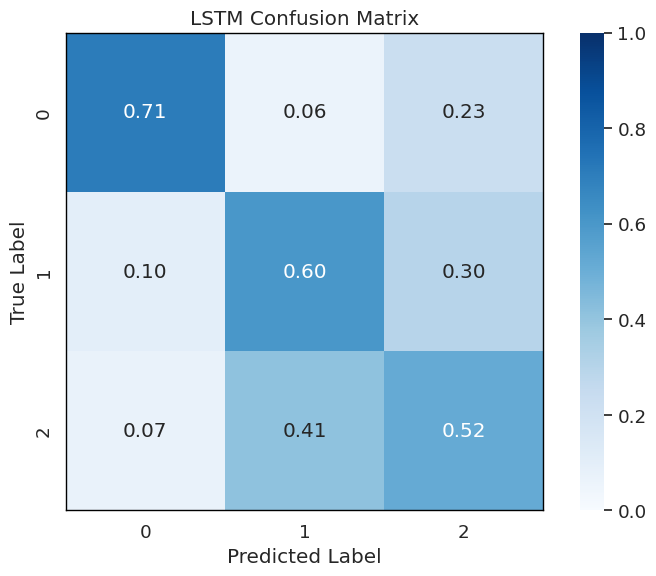

In [ ]:
def plot_confusion_matrix(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_test_classes = np.argmax(y_test, axis=-1)

    # Flatten the predictions and true labels
    y_pred_classes_flat = y_pred_classes.flatten()
    y_test_classes_flat = y_test_classes.flatten()

    # Compute the confusion matrix
    confusion_mtx = sklearn.metrics.confusion_matrix(y_test_classes_flat, y_pred_classes_flat, normalize="true")

    # Set up the matplotlib figure
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Create the heatmap
    heatmap = sns.heatmap(confusion_mtx, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1, square=True)

    # Customize the axes and titles
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('LSTM Confusion Matrix')

    # Add a black border around the entire heatmap
    ax = plt.gca()  # Get the current axes
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    # Set the border color to black
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Set the border width to make it more visible
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, shaped_test_data, shaped_test_target)

In [13]:
def train_lstm_model_with_kfold(series, target, class_weights, k=3):
    series = np.array(series, dtype=np.float32)
    target = np.array(target, dtype=np.int32)
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    histories = []
    fold_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(series)):
        print(f"\nTraining fold {fold+1}/{k}...")
        
        # Split data
        X_train, X_val = series[train_idx], series[val_idx]
        y_train, y_val = target[train_idx], target[val_idx]
        
        # Build model
        input_shape = X_train.shape[1:]
        model = build_lstm_model(input_shape)
        model.compile(loss=weighted_categorical_crossentropy(class_weights),
                      optimizer='adam', metrics=['accuracy'])
        
        # Early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train model
        history = model.fit(X_train, y_train, batch_size=32, epochs=20,
                            validation_data=(X_val, y_val), callbacks=[early_stop])
        
        histories.append(history)
        
        # Evaluate model
        y_pred = model.predict(X_val)
        y_pred_flat = y_pred.reshape(-1, 3)
        y_val_flat = y_val.reshape(-1, 3)
        
        y_pred_classes = np.argmax(y_pred_flat, axis=1)
        y_val_classes = np.argmax(y_val_flat, axis=1)
        
        # Compute metrics per class
        precision = precision_score(y_val_classes, y_pred_classes, average=None, zero_division=0)
        recall = recall_score(y_val_classes, y_pred_classes, average=None, zero_division=0)
        f1 = f1_score(y_val_classes, y_pred_classes, average=None, zero_division=0)
        accuracy = accuracy_score(y_val_classes, y_pred_classes)
        
        fold_metrics.append({
            'fold': fold+1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
        
    return histories, fold_metrics

histories, fold_metrics = train_lstm_model_with_kfold(shaped_train_data, shaped_train_target, class_weights)


Training fold 1/3...
Epoch 1/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.4658 - loss: 0.3473 - val_accuracy: 0.5087 - val_loss: 0.3273
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.5110 - loss: 0.3297 - val_accuracy: 0.5156 - val_loss: 0.3298
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5064 - loss: 0.3326 - val_accuracy: 0.5352 - val_loss: 0.3149
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.5278 - loss: 0.3229 - val_accuracy: 0.5562 - val_loss: 0.3099
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.5334 - loss: 0.3195 - val_accuracy: 0.5460 - val_loss: 0.3099
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5381 - loss: 0.3155 - val_accuracy: 0.5473 - val_loss: 0.3143
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.5433 - loss: 0.3129 - val_accuracy: 0.5538 - val_loss: 0.3091
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.

In [19]:
def plot_loss(histories):
    plt.figure(figsize=[8,6])
    
    # Define a list of colors to cycle through for each fold
    colors = plt.cm.Set2(range(0, len(histories)))  # Get distinct colors for each fold
    
    # Loop through each fold's history and plot the loss curves
    for fold, (history, color) in enumerate(zip(histories, colors)):
        # Plot training loss for each fold
        plt.plot(history.history['loss'], label=f'Fold {fold+1} Training Loss', color=color, linewidth=2.0)
        # Plot validation loss for each fold, with the same color but dashed and lighter
        plt.plot(history.history['val_loss'], label=f'Fold {fold+1} Validation Loss', color=color, linestyle='--', alpha=0.7, linewidth=2.0)

    # Configure the plot
    plt.legend(fontsize=10)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Loss Curves Across Folds', fontsize=14)
    plt.show()

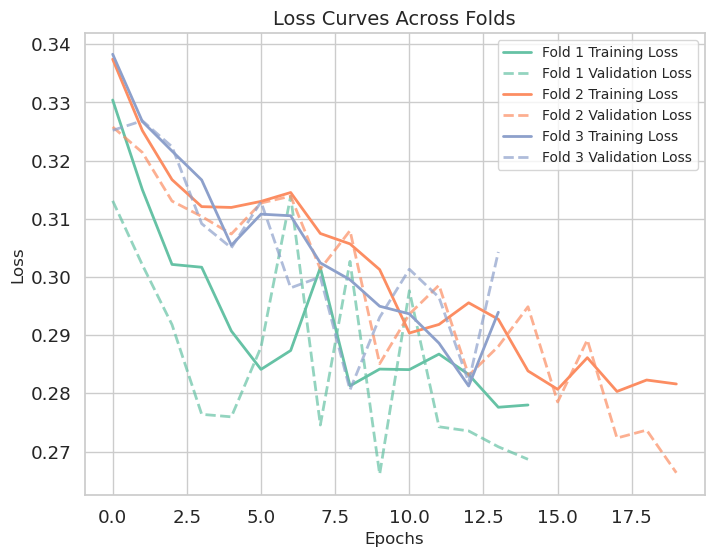

In [20]:
plot_loss(histories)

In [ ]:
def print_fold_metrics_summary(fold_metrics):
    # Convert fold_metrics (list of dicts) into a DataFrame
    metrics_df = pd.DataFrame(fold_metrics)
    
    # Flatten the precision, recall, and f1_score arrays for each class into a single average value per fold
    metrics_df['precision'] = metrics_df['precision'].apply(lambda x: np.mean(x))
    metrics_df['recall'] = metrics_df['recall'].apply(lambda x: np.mean(x))
    metrics_df['f1_score'] = metrics_df['f1_score'].apply(lambda x: np.mean(x))
    
    # Calculate mean and standard error for each metric
    summary_df = pd.DataFrame({
        'Metric': ['accuracy', 'precision', 'recall', 'f1_score'],
        'Mean': [
            metrics_df['accuracy'].mean(),
            metrics_df['precision'].mean(),
            metrics_df['recall'].mean(),
            metrics_df['f1_score'].mean()
        ],
        'Standard Error': [
            metrics_df['accuracy'].std() / np.sqrt(len(metrics_df)),
            metrics_df['precision'].std() / np.sqrt(len(metrics_df)),
            metrics_df['recall'].std() / np.sqrt(len(metrics_df)),
            metrics_df['f1_score'].std() / np.sqrt(len(metrics_df))
        ]
    })

    # Print the summary table
    print(summary_df.to_string(index=False))

# Example usage:
print_fold_metrics_summary(fold_metrics)


   Metric     Mean  Standard Error
 accuracy 0.596359        0.012040
precision 0.610081        0.018688
   recall 0.596332        0.012055
 f1_score 0.599875        0.014739


In [24]:
def print_overall_metrics(metrics):
    # Specify the desired order of metrics
    metric_order = ['accuracy', 'precision', 'recall', 'f1_score']
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
    # Reindex the DataFrame to ensure the desired order
    metrics_df = metrics_df.reindex(metric_order)
    # Print the metrics table
    print(metrics_df.to_string(index=True, header=False))

print_overall_metrics(metrics)

accuracy                                                         0.57461
precision   [0.6617721245315653, 0.5527479215470121, 0.5062896675398654]
recall     [0.7065454178228107, 0.46388732285778994, 0.5532028315932034]
f1_score    [0.6834262483050867, 0.5044341221748027, 0.5287076178804695]


In [25]:
model.save("model_lstm.keras")